### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 4
### Due: Saturday, Feb 26th at 11.59pm CST
---

## Problem 1

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw4_data_1.npy`. This is a (10 x 2) numpy array, with voltage measurements in the first column and heteroscedastic voltage uncertainties in the second column. Compute the sample mean and the standard error on the sample mean for this data.

2) Fit the appropriate ln-likelihood function and find the best-fit mean voltage.

3) Compute and plot the Bayesian posterior probability density (*not the log posterior*) for the mean voltage assuming a uniform prior for the mean in the range 3 to 7. Make sure this posterior pdf is normalized!

4) By either drawing samples from this posterior, or using your gridded posterior pdf to make a cdf, find the equal-tailed 68.3% credible region for the mean, and compare the upper and lower boundaries to the sample mean plus/minus the standard error, respectively. *Also* find the MAP value of the mean.

5) Repeat (3) and (4) this time with a prior on the mean that is uniform in the range 4.6 to 5.4. 

6) Now, imagine that we read an old paper about the experiment that gave us the voltage measurements, and they found that the mean was actually $6\pm0.3$. Repeat (3) and (4) this time with a Gaussian prior on the mean centered at $6$ with standard deviation of $0.3$.

7) Plot all of the normalized posterior pdfs for $\mu$ from (3), (5), and (6) on the same plot, making sure that the xlim of the plot spans 0 to 10.

8) You have made sure that the posterior pdfs are properly normalized, but until now you have ignored the meaning of that normalization constant. It is the Bayesian evidence for the particular model you have applied! Compute the evidence under a new model where the prior for the mean is a delta function at the best-fit value you found in (1) *(think about this and don't just immediately go looking for a `scipy.stats` delta function)*. Compare this to the evidence found under the prior in (3). Taking ratios to make a Bayes factor, which model is favored? Is there much of an Occam penalty by having the wide prior compared to knowing the mean exactly? 

### Solution

In [145]:
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'
import scipy
from scipy import optimize
from scipy.interpolate import interp1d
from scipy.stats import norm

#### Part 1

In [2]:
#reading in data
data = np.load('/Users/petrop3/Repos/astr_8070_s22/coursework/homeworks/hw_data/hw4_data_1.npy')
volts = data[:,0]
volt_uncs = data[:,1]

Computing sample mean according to:
$$\hat \mu = \frac{\sum_i^N (x_i/\sigma_i^2)}{\sum_i^N (1/\sigma_i^2)},$$

and standard error on sample mean according to:
$$\sigma_{\mu} = \left( \sum_{i=1}^N \frac{1}{\sigma_i^2}\right)^{-1/2}.$$

In [5]:
#computing sample mean
xbar = sum(volts/volt_uncs**2) / sum(1/volt_uncs**2)
print('Sample mean:',xbar)

#computing std error on sample mean for heteroscedastic gaussian
sigma_mu = (sum(1/volt_uncs**2))**(-1/2)
print('Standard error on sample mean:',sigma_mu)

Sample mean: 4.942118214425304
Standard error on sample mean: 0.43024334605205083


#### Part 2

Using the following equation for lnL (and ignoring the constant):

$$\ln L = {\rm constant} - \sum_{i=1}^N \frac{(x_i - \mu)^2}{2\sigma_i^2}.$$

In [8]:
#function for log likelihood
def log_lh(data,sigma,mu):
    ll = -(sum((data-mu)**2 / (2*sigma**2) ))
    return ll

min_mean_func = lambda m: -1*(log_lh(volts,volt_uncs,m)) #multiplying by -1 as we want to minimize -logL with scipy

opt_mean = optimize.fmin(min_mean_func, x0=0) #initial guess of mean=0
print('Best fit mean:',opt_mean[0])

Optimization terminated successfully.
         Current function value: 2.807251
         Iterations: 29
         Function evaluations: 58
Best fit mean: 4.942125000000006


#### Part 3

In [108]:
#defining likelihood for heteroscedastic gaussian
#ignoring the constant
def L(data, mu, sigma):
    likelihood = (1/(sigma*np.sqrt(2*np.pi)))*np.exp((-(data-mu)**2)/(2*sigma**2))
    return likelihood

#defining uniform prior for range 3-7
def prior(mu):
    return 1/(7-3)

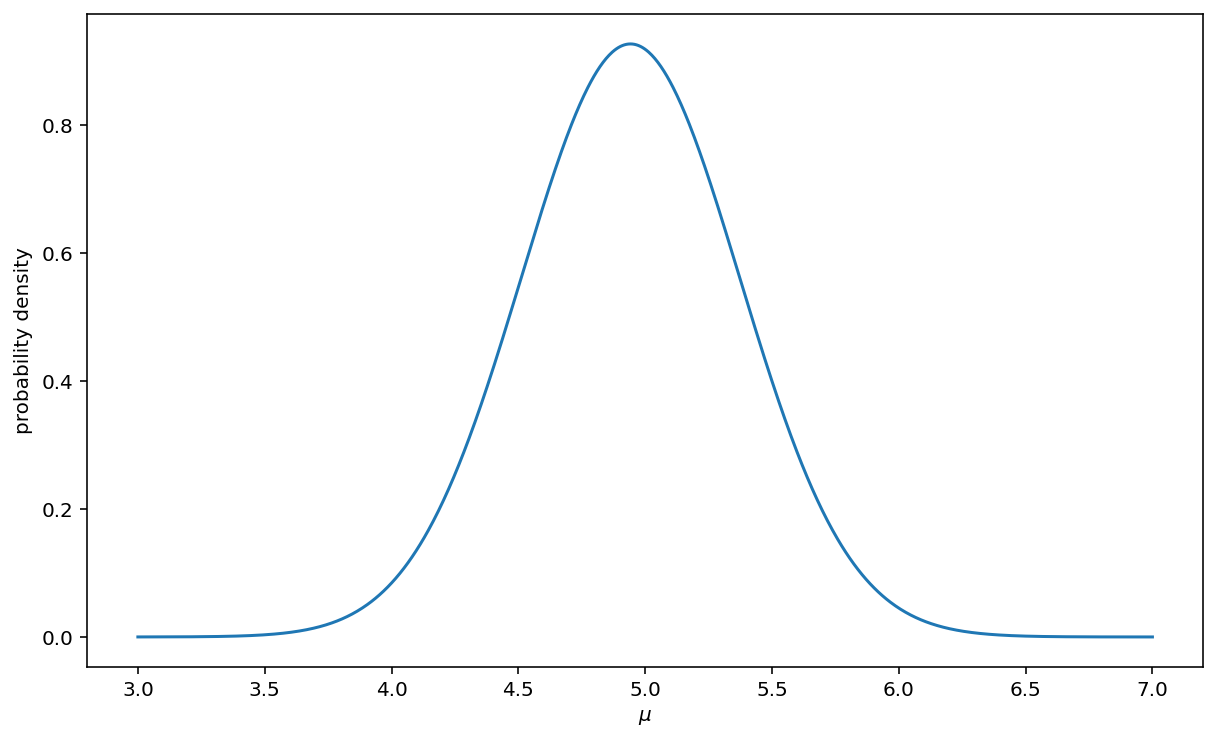

In [109]:
fig, ax = plt.subplots(figsize=(10,6))

mu = np.linspace(3, 7, 1000) #mu values
probs = [L(volts, m, volt_uncs) * prior(m) for m in mu] #multiplying likelihood x prior for each mu
posterior = [np.prod(p) for p in probs] #product for each mu

x = mu[1] - mu[0] #getting spacing between mu values, Δmu
post_sum = np.sum(np.array([y*x for y in posterior])) #Riemann summing to get total area under curve
pdf = posterior/post_sum

ax.plot(mu, pdf) #plotting normalized posterior
plt.xlabel(r'$\mu$')
plt.ylabel('probability density')
plt.show()

#### Part 4

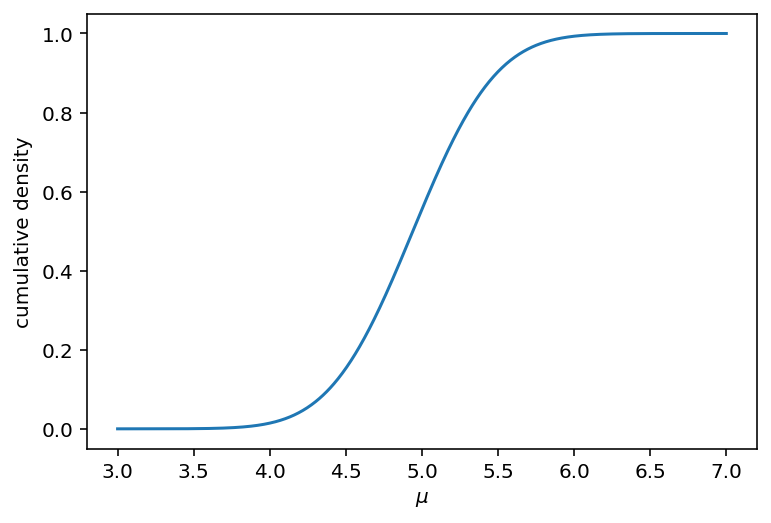

In [110]:
#making sure cdf looks right
cdf = np.cumsum(pdf)*x #getting cdf by finding cumulative sum of pdf x delta mu
plt.plot(mu, cdf)
plt.xlabel(r'$\mu$')
plt.ylabel('cumulative density')
plt.show()

Equal-tailed 68.3% credible region is between μ=4.509602276191736 and μ=5.37063491252702.


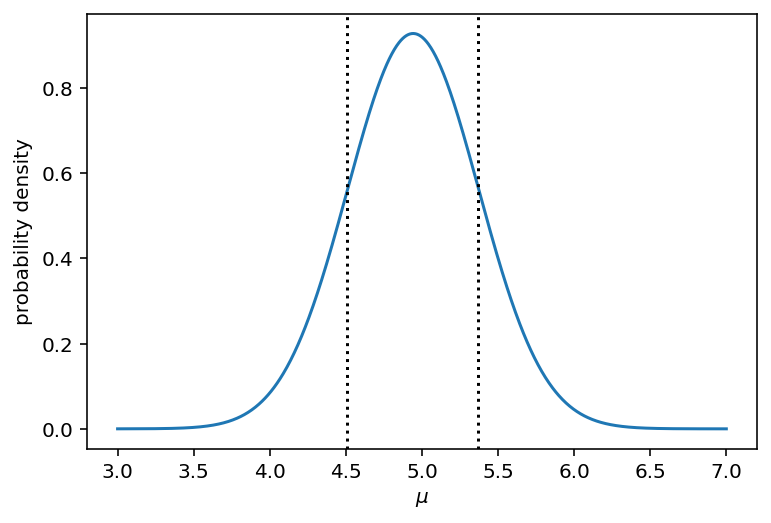

In [111]:
#(100 - 68.3) / 2 = 15.85% in each tail
#find where cumulative density is 15.85% and 100-15.85 = 84.15%

cdfFunc = interp1d(cdf, mu) #interpolating between existing mu and cdf values
leftTailmu = cdfFunc(0.1585) #finding mu value at 15.85%
rightTailmu = cdfFunc(0.8415) #finding mu value at 84.15%

print(f'Equal-tailed 68.3% credible region is between μ={leftTailmu} and μ={rightTailmu}.')

plt.plot(mu, pdf)
plt.axvline(leftTailmu, color='k', ls=':')
plt.axvline(rightTailmu, color='k', ls=':')
plt.xlabel(r'$\mu$')
plt.ylabel('probability density')
plt.show()

In [112]:
#comparing to sample mean +/- std error
print(f'Equal-tailed 68.3% credible region is between μ={xbar-sigma_mu} and μ={xbar+sigma_mu}.')

Equal-tailed 68.3% credible region is between μ=4.511874868373253 and μ=5.372361560477355.


This agrees pretty well, to a couple decimal places.

In [113]:
#MAP value of the mean
#this will be the mu at which the pdf is a maximum
index = np.argmax(pdf)
MAP_mu = mu[index]
print(f'MAP value of the mean is {MAP_mu}.')

MAP value of the mean is 4.941941941941942.


#### Part 5

In [114]:
#defining uniform prior for range 4.6-5.4
def prior2(mu):
    return 1/(5.4-4.6)

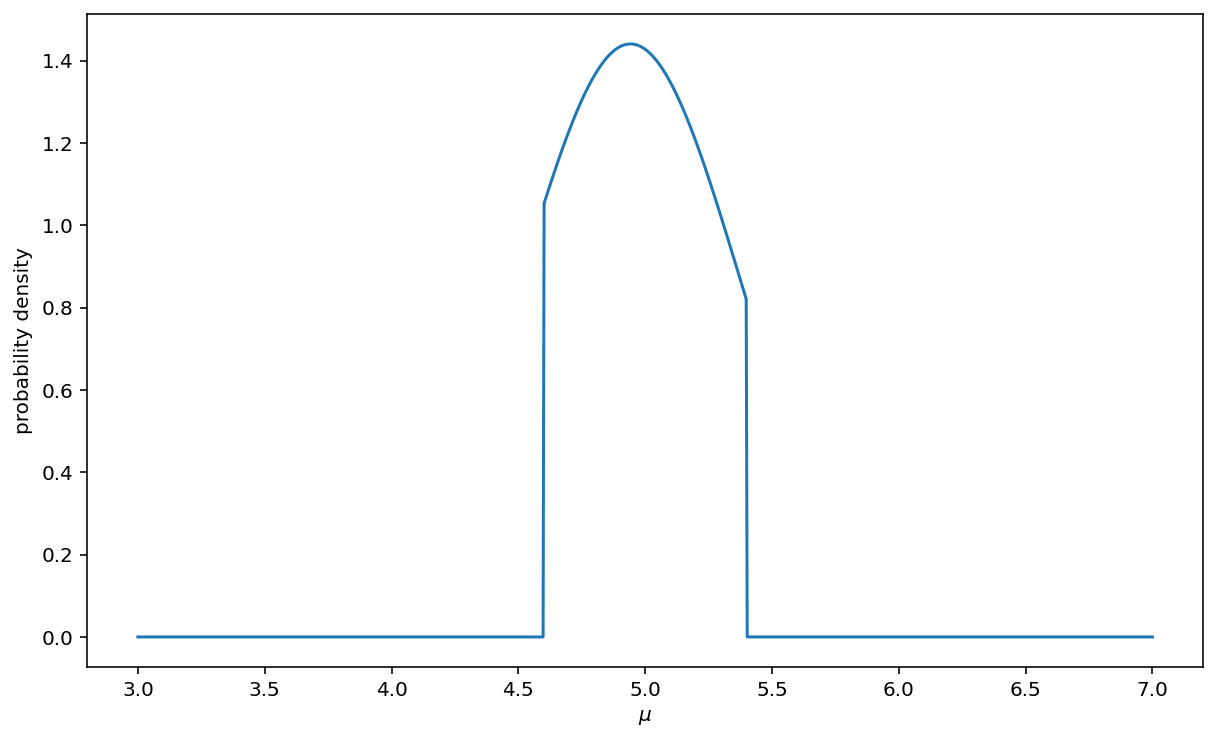

In [115]:
fig, ax = plt.subplots(figsize=(10,6))

mu = np.linspace(3, 7, 1000) #mu values
probs = []
for m in mu:
    if m < 4.6 or m > 5.4:
        probs.append(0.0) #append 0 if outside of prior range
    else:
        probs.append(L(volts, m, volt_uncs) * prior2(m)) #multiplying likelihood x prior for each mu
posterior = [np.prod(p) for p in probs] #product for each mu

x = mu[1] - mu[0] #getting spacing between mu values, Δmu
post_sum = np.sum(np.array([y*x for y in posterior])) #Riemann summing to get total area under curve
pdf = posterior/post_sum

ax.plot(mu, pdf) #plotting normalized posterior
plt.xlabel(r'$\mu$')
plt.ylabel('probability density')
plt.show()

Equal-tailed 68.3% credible region is between μ=4.732853290330594 and μ=5.236555564183138.


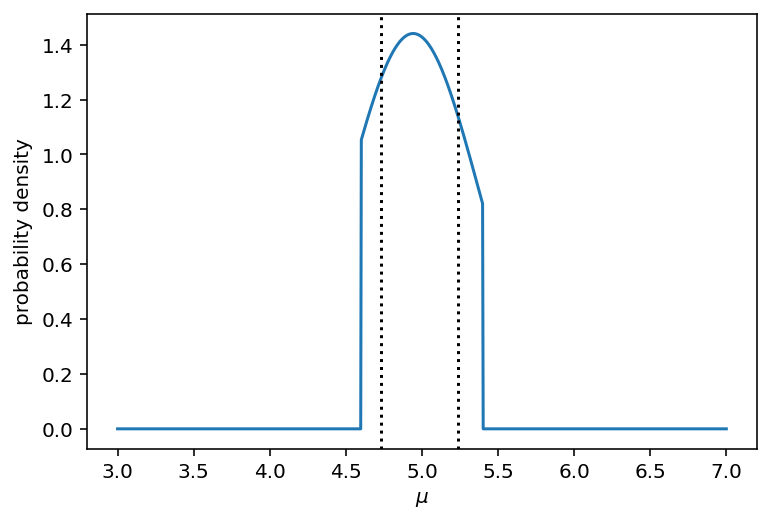

In [116]:
cdf = np.cumsum(pdf)*x #getting cdf by finding cumulative sum of pdf x delta mu

cdfFunc = interp1d(cdf, mu) #interpolating between existing mu and cdf values
leftTailmu = cdfFunc(0.1585) #finding mu value at 15.85%
rightTailmu = cdfFunc(0.8415) #finding mu value at 84.15%

print(f'Equal-tailed 68.3% credible region is between μ={leftTailmu} and μ={rightTailmu}.')

plt.plot(mu, pdf)
plt.axvline(leftTailmu, color='k', ls=':')
plt.axvline(rightTailmu, color='k', ls=':')
plt.xlabel(r'$\mu$')
plt.ylabel('probability density')
plt.show()

In [117]:
#comparing to sample mean +/- std error
print(f'Equal-tailed 68.3% credible region is between μ={xbar-sigma_mu} and μ={xbar+sigma_mu}.')

Equal-tailed 68.3% credible region is between μ=4.511874868373253 and μ=5.372361560477355.


Not quite the same, off by a few tenths.

In [118]:
#MAP value of the mean
#this will be the mu at which the pdf is a maximum
index = np.argmax(pdf)
MAP_mu = mu[index]
print(f'MAP value of the mean is {MAP_mu}.')

MAP value of the mean is 4.941941941941942.


#### Part 6

Log likelihood (including constant) is:

$$\ln L = \sum_{i=l}^N \ln \left( \frac{1}{\sqrt{2\pi\sigma_i^2}} \right) - \sum_{i=1}^N \frac{(x_i - \mu)^2}{2\sigma_i^2}.$$

In [135]:
#defining gaussian prior centered at 6 with sigma 0.3
distN = norm(6, 0.3)
def prior3(mu):
    return distN.pdf(mu)

#defining likelihood for heteroscedastic gaussian
#this time including the constant since this isn't a uniform prior
#taking exp() of the above equation to get likelihood
def L2(data, mu, sigma):
    likelihood = np.exp(np.sum(np.log(1/np.sqrt(2*np.pi*sigma**2))) - np.sum((data-mu)**2/(2*sigma**2)))
    return likelihood

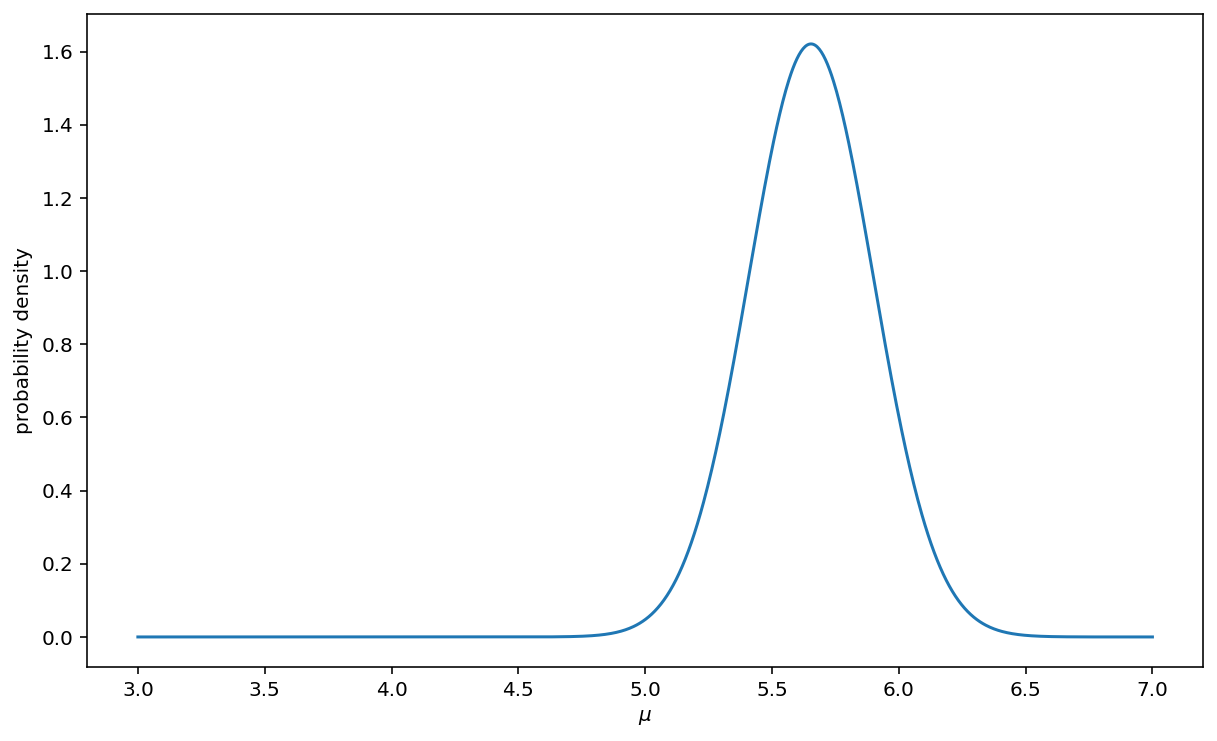

In [126]:
fig, ax = plt.subplots(figsize=(10,6))

mu = np.linspace(3, 7, 1000) #mu values
probs = [L2(volts, m, volt_uncs) * prior3(m) for m in mu] #multiplying likelihood x prior for each mu
posterior = [np.prod(p) for p in probs] #product for each mu

x = mu[1] - mu[0] #getting spacing between mu values, Δmu
post_sum = np.sum(np.array([y*x for y in posterior])) #Riemann summing to get total area under curve
pdf = posterior/post_sum

ax.plot(mu, pdf) #plotting normalized posterior
plt.xlabel(r'$\mu$')
plt.ylabel('probability density')
plt.show()

Equal-tailed 68.3% credible region is between μ=5.405675999898818 and μ=5.89816347938735.


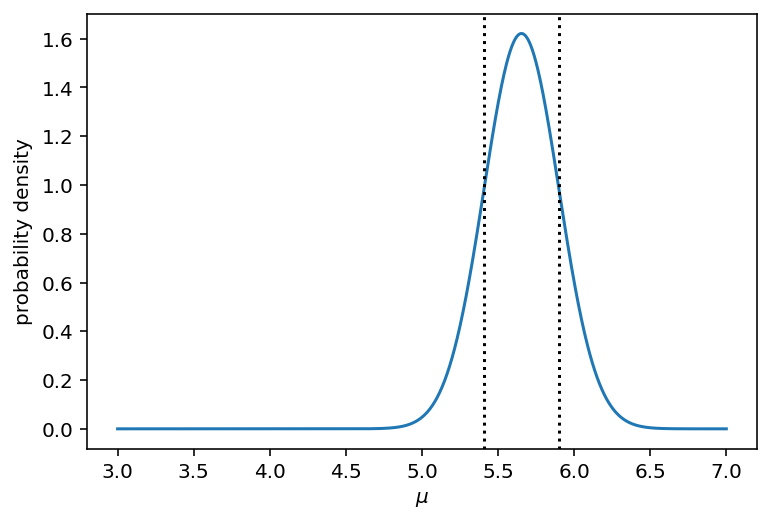

In [127]:
cdf = np.cumsum(pdf)*x #getting cdf by finding cumulative sum of pdf x delta mu

cdfFunc = interp1d(cdf, mu) #interpolating between existing mu and cdf values
leftTailmu = cdfFunc(0.1585) #finding mu value at 15.85%
rightTailmu = cdfFunc(0.8415) #finding mu value at 84.15%

print(f'Equal-tailed 68.3% credible region is between μ={leftTailmu} and μ={rightTailmu}.')

plt.plot(mu, pdf)
plt.axvline(leftTailmu, color='k', ls=':')
plt.axvline(rightTailmu, color='k', ls=':')
plt.xlabel(r'$\mu$')
plt.ylabel('probability density')
plt.show()

In [128]:
#comparing to sample mean +/- std error
print(f'Equal-tailed 68.3% credible region is between μ={xbar-sigma_mu} and μ={xbar+sigma_mu}.')

Equal-tailed 68.3% credible region is between μ=4.511874868373253 and μ=5.372361560477355.


The 68.3% credible region calculated from this Gaussian prior doesn't even overlap with the credible region given by the sample mean +/- the standard error.

In [129]:
#MAP value of the mean
#this will be the mu at which the pdf is a maximum
index = np.argmax(pdf)
MAP_mu = mu[index]
print(f'MAP value of the mean is {MAP_mu}.')

MAP value of the mean is 5.654654654654655.


#### Part 7

In [130]:
#prior 1, uniform between 3-7
mu = np.linspace(0, 10, 1000)
probs = [L(volts, m, volt_uncs) * prior(m) for m in mu]
posterior = [np.prod(p) for p in probs]
x = mu[1] - mu[0]
post_sum = np.sum(np.array([y*x for y in posterior]))
pdf1 = posterior/post_sum

#prior2, uniform between 4.6-5.4
probs = []
for m in mu:
    if m < 4.6 or m > 5.4:
        probs.append(0.0)
    else:
        probs.append(L(volts, m, volt_uncs) * prior2(m))
posterior = [np.prod(p) for p in probs]

x = mu[1] - mu[0]
post_sum = np.sum(np.array([y*x for y in posterior]))
pdf2 = posterior/post_sum

#prior 3, gaussian with loc=6, scale=0.3
probs = [LL(volts, m, volt_uncs) * prior3(m) for m in mu]
posterior = [np.prod(p) for p in probs]
x = mu[1] - mu[0]
post_sum = np.sum(np.array([y*x for y in posterior]))
pdfG = posterior/post_sum

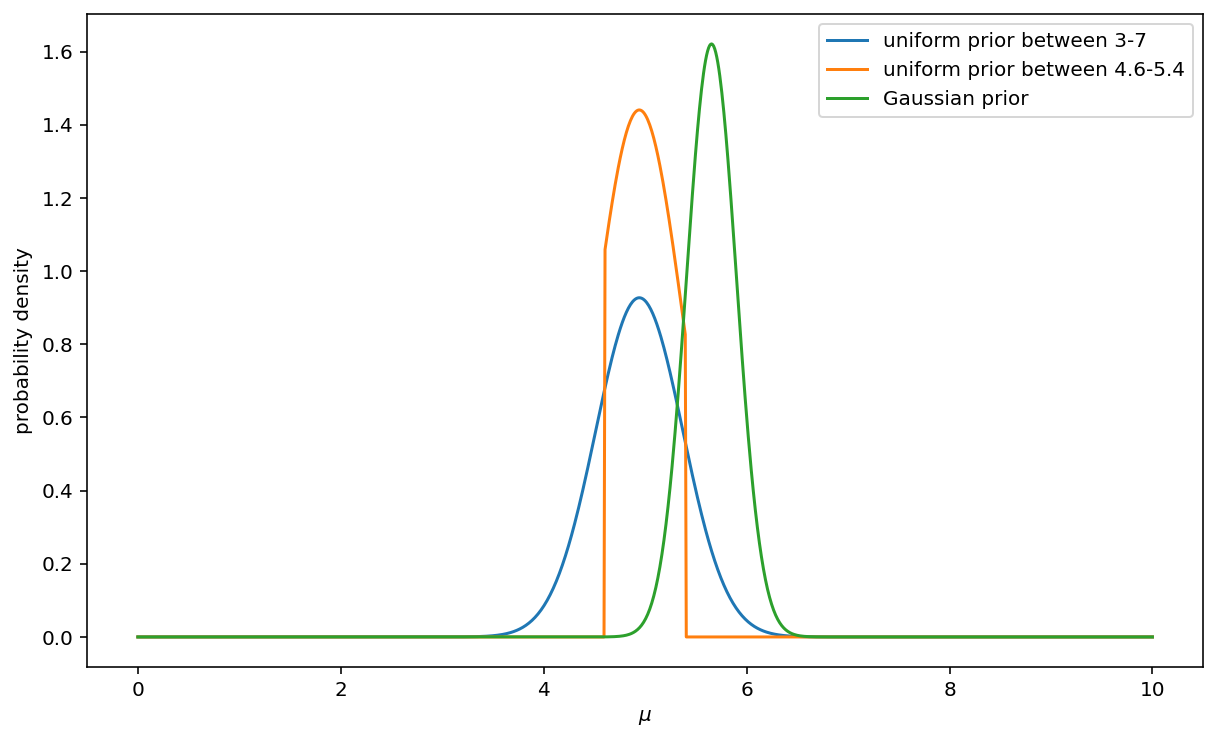

In [133]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(mu, pdf1, label='uniform prior between 3-7')
ax.plot(mu, pdf2, label='uniform prior between 4.6-5.4')
ax.plot(mu, pdfG, label='Gaussian prior')
plt.xlabel(r'$\mu$')
plt.ylabel('probability density')
plt.legend()
plt.show()

#### Part 8

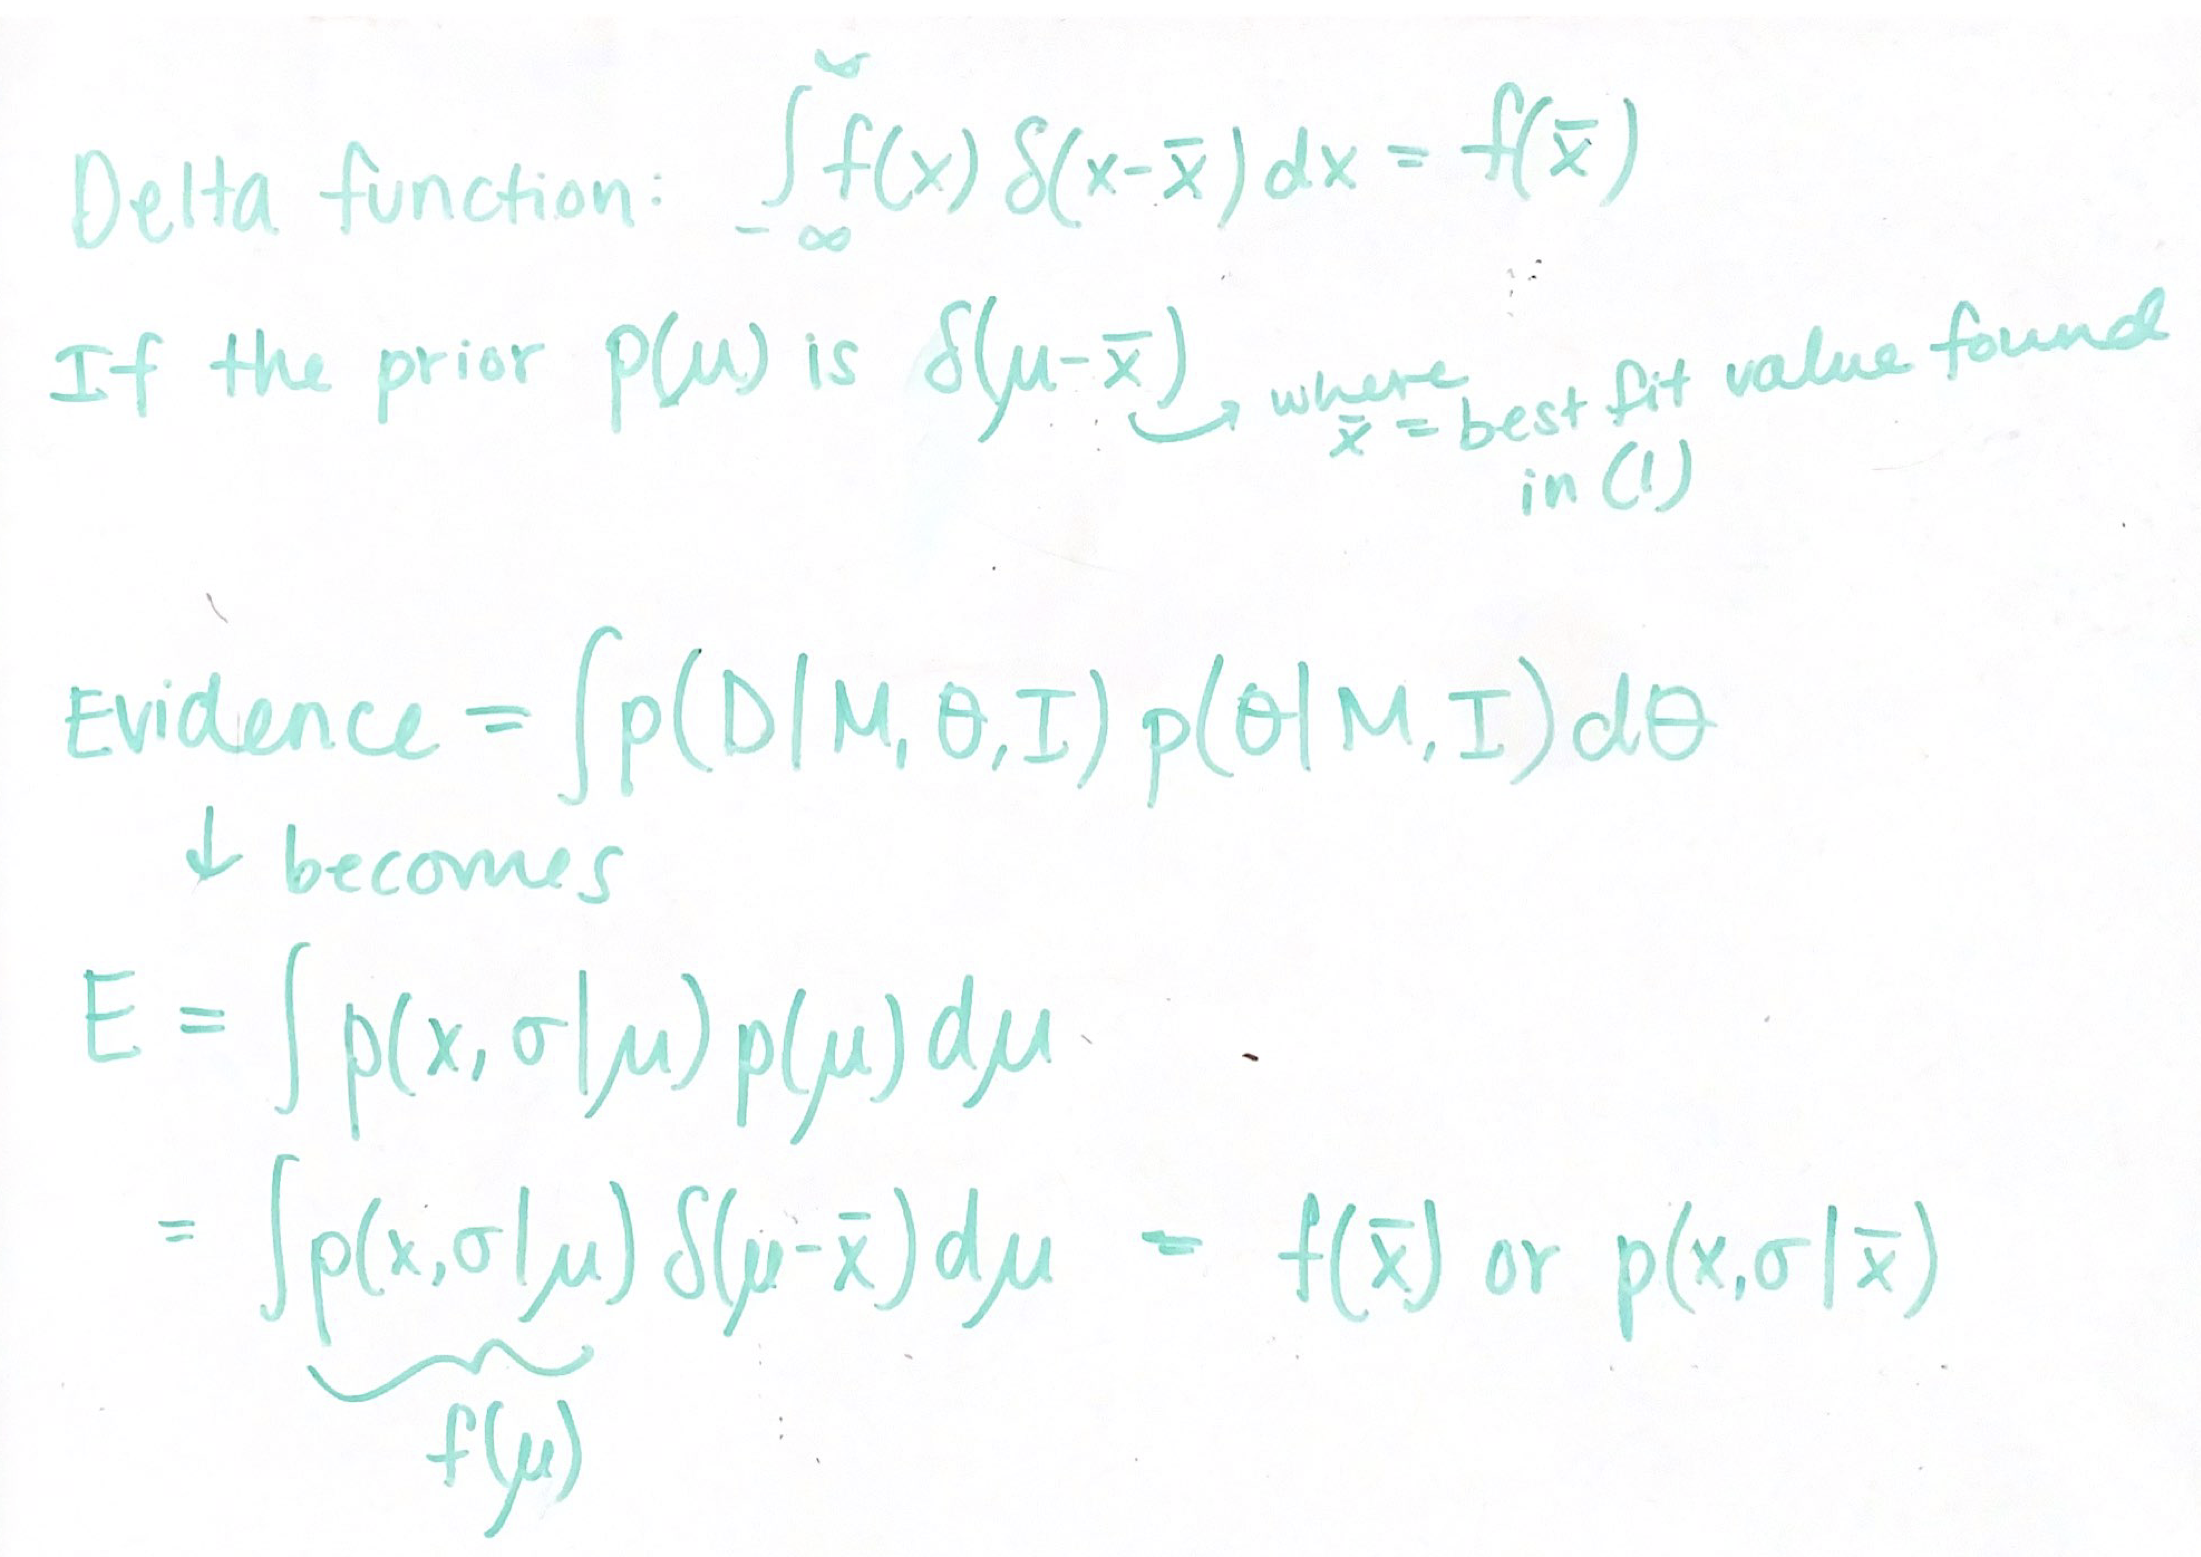

In [138]:
#so evidence for delta function will just be the likelihood at the best-fit value from (1)
E_priorD = L2(volts, xbar, volt_uncs)
print('Evidence for delta prior:', E_priorD)

#evidence for prior from (3) --> uniform prior between 3-7
#summing likelihood x prior and multiplying by dμ (defined as x) to get evidence integral
E_prior1 = np.sum([L2(volts, m, volt_uncs)*prior(m) for m in mu])*x
print('Evidence for wide prior:', E_prior1)

Evidence for delta prior: 1.0725971348964463e-07
Evidence for wide prior: 2.891883130432624e-08


In [139]:
print('Bayes factor:', E_priorD/E_prior1)

Bayes factor: 3.708991983835759


The delta function prior is favored over the wide uniform prior. From the Bayes factor chart we saw in Lecture 9, a 3:1 - 10:1 Bayes factor can be described as showing substantial evidence for the first model over the second -- in this case, the delta function. Comparing the two priors, the wide prior does have some Occam penalty as it involves searching over a range of parameters, whereas the delta function simply searches over the exact mean.

## Problem 2

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw4_data_2.npy`, which is a (3 x 20) numpy array that you used in `Lecture_9`. Set `x, y, sigma_y = data`. 

We're going to do some polynomial fits to this data just like in the lecture. However, in all cases you should **keep the $y$-intercept fixed at $-0.23$**. 

2) Use the following code to compute the un-normalized posterior pdf (i.e. just the likelihood x prior) on a grid of the linear coefficient (i.e. the slope) of a linear model, with a uniform prior between 0.5 and 1.5. Plot this posterior pdf. Remember this is just a one-dimensional model because the $y$-intercept is fixed. I advise a grid size of 100.

In [147]:
#Functions to do a polynomial fit, and compute the likelihood
def polynomial_fit(theta, x):
    """Polynomial model of degree (len(theta) - 1)"""
    # For a polynomial with order 1, this gives theta_0 + theta_1*x
    # For a polynomial with order 2, this gives theta_0 + theta_1*x + theta_2*x^2, etc.
    return sum(t * x ** n for (n, t) in enumerate(theta))

# compute the data log-likelihood given a model
def logL(theta, data, model=polynomial_fit):
    """Gaussian log-likelihood of the model at theta"""
    x, y, sigma_y = data
    y_fit = model(theta, x)
    return sum(scipy.stats.norm.logpdf(*args) 
               for args in zip(y, y_fit, sigma_y))

3) Using your 1D gridded likelihood-x-prior, compute the Bayesian evidence of this linear model. This may be a big number!

4) Now compute the joint 2D posterior pdf (again just the likelihood x prior) of linear and quadratic coefficients of a quadratic model. Give the linear coefficient a uniform prior between 0.5 and 1.5. Give the quadratic coefficient a uniform prior between -1 and 0.25. Plot this two-dimensional posterior. Remember this is a two-dimensional model because the $y$-intercept is fixed. I advise a grid size of 100 in each model dimension.

5) Using your 2D gridded likelihood-x-prior, compute the Bayesian evidence of the quadratic model. 

6) Calculate the Bayes factor for a linear versus quadratic model. How does this compare/contrast with the BIC model comparison in the lecture? 

### Solution

#### Part 1

In [148]:
#reading in data
data2 = np.load('/Users/petrop3/Repos/astr_8070_s22/coursework/homeworks/hw_data/hw4_data_2.npy')
x, y, sigma_y = data2

#### Part 2

In [153]:
#defining y-intercept and slope values
theta0 = -0.23
theta1 = np.linspace(0.5, 1.5, 100)

In [158]:
#defining prior for linear coefficient
def priorX(t1):
    return 1/(1.5-0.5)

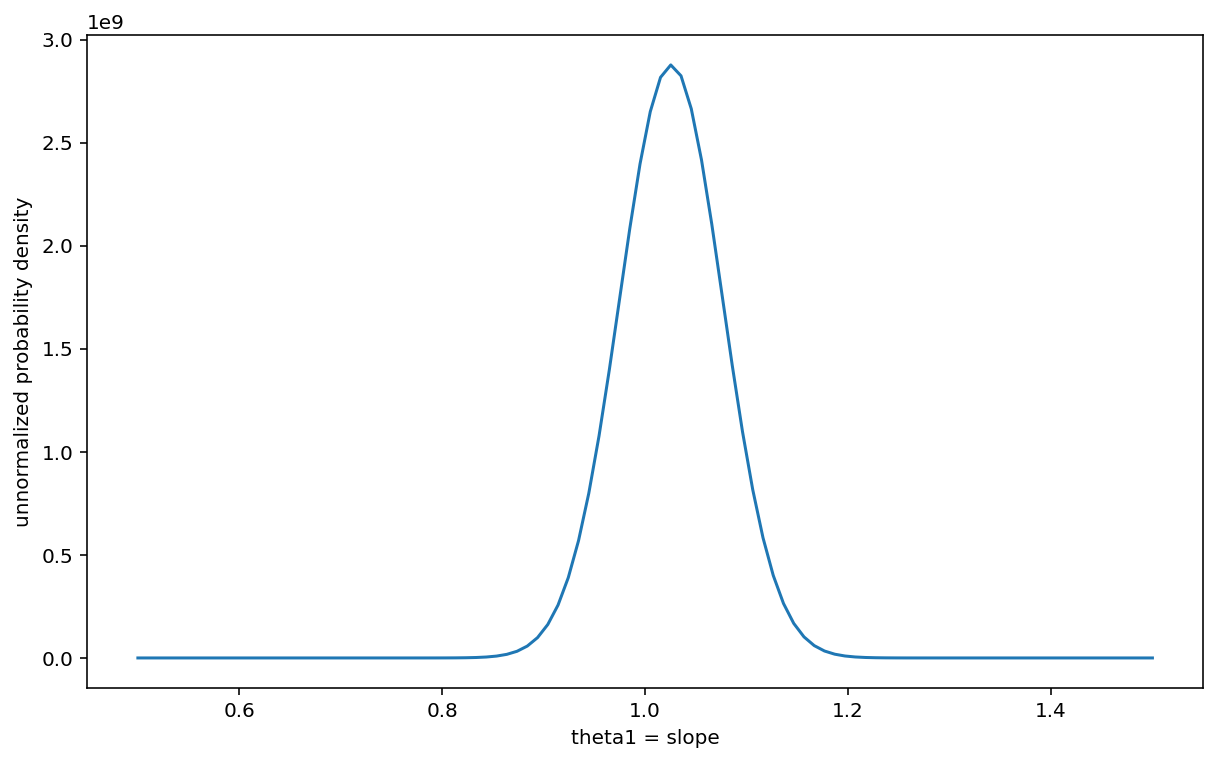

In [159]:
post = [np.exp(logL([theta0,t1], data2, model=polynomial_fit))*priorX(t1) for t1 in theta1]

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(theta1, post)
plt.xlabel('theta1 = slope')
plt.ylabel('unnormalized probability density')
plt.show()

#### Part 3

In [156]:
E_linear = np.sum(post)*(theta1[1]-theta1[0])
print('Evidence for linear model:', E_linear)

Evidence for linear model: 365684733.1606578


#### Part 4

In [160]:
#defining prior for quadratic coefficient
def priorXX(t2):
    return 1/(0.25-(-1))

In [166]:
#joint 2D posterior pdf
#want likelihood x prior for each pair of linear & quadratic terms

theta2 = np.linspace(-1, 0.25, 100)
post_grid = []
for l in range(len(theta1)):
    row = []
    t1 = theta1[l]
    for q in range(len(theta2)):
        t2 = theta2[q]
        prob = np.exp(logL([theta0, t1, t2], data2, model=polynomial_fit))*priorX(t1)*priorXX(t2)
        row.append(prob)
    post_grid.append(row)

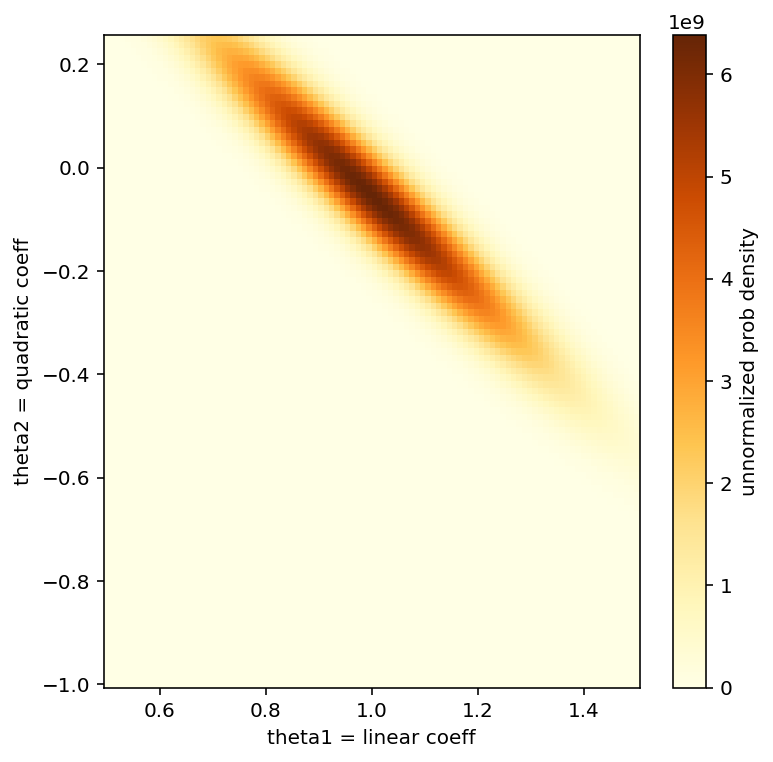

In [167]:
#plotting 2d posterior

plt.figure(1, figsize=(6,6))
plt.pcolormesh(theta1, theta2, post_grid, cmap='YlOrBr')
plt.colorbar(label='unnormalized prob density')
plt.xlabel('theta1 = linear coeff')
plt.ylabel('theta2 = quadratic coeff')
plt.show()

#### Part 5

In [168]:
E_quadratic = np.sum(post_grid)*(theta1[1]-theta1[0])*(theta2[1]-theta2[0])
print('Evidence for linear model:', E_quadratic)

Evidence for linear model: 493061001.65705675


#### Part 6

In [172]:
print('Bayes factor:', E_linear/E_quadratic)

Bayes factor: 0.7416622526050152


In our case, the Bayes factor just barely favors the quadratic model over the linear model. In Lecture 9, we saw that using the BIC to choose the best polynomial for a line fit gives us a value of 17.31 for the linear fit and 18.45 for the quadratic fit (for N=20 data points). In that case, the linear model was just barely favored. While the two methods of Bayesian model comparison yield different results, in both cases the winning model is not substantially favored, and ultimately either model can be used.